# ML Experiments

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

In [2]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [3]:
from m5.metrics import get_weights, get_rmsse, get_wrmsse, wrmsse_per_level, wrmsse_total

In [4]:
import pickle
from pathlib import Path

def xnow() -> str:
    return pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")

## Prepare Data

### Load

In [5]:
ds_all = load_ds()

In [6]:
ds = ds_all.where(ds_all['historic'], drop=True).drop(["historic", "future"])
# Fix dtype changes due to "where" mask
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

### Fixes and checks

Fill the price for when we don't know it:

In [7]:
ds['price'] = ds['price'].ffill(dim="date").bfill(dim="date")

Check that all values are nonnegative:

In [8]:
(ds<0).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

Check that we don't have any nulls in our data:

In [9]:
ds.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sales    int64 0
    price    int64 0
    wday     int64 0
    month    int64 0
    year     int64 0
    event    int64 0
    snap     int64 0

### Create Features

We will calculate features now, to avoid having to create a pipeline.
(It's not available in nd_learn yet, and I don't have enough time to code it)

In [10]:
# raw_ds = ds.copy()

We can't use target lags directly, because we must do a prediction many steps ahead!

Categorical features (as integers, because LightGBM can encode them natively)

In [11]:
ds.coords['category'] = np.unique(ds['cat_id'])
ds.coords['department'] = np.unique(ds['dept_id'])
ds.coords['state'] = np.unique(ds['state_id'])
ds.coords['store'] = np.unique(ds['store_id'])
ds.coords['item'] = np.unique(ds['item_id'])

In [12]:
def get_feat(ds, a: str, b: str) -> xr.DataArray:
    q = (ds[a] == ds[b])
    q.coords[b] = np.arange(len(q[b]))
    return q.idxmax(dim=b)

In [13]:
ds["feat_category"] = get_feat(ds, 'cat_id', 'category')
ds["feat_department"] = get_feat(ds, 'dept_id', 'department')
ds["feat_item"] = get_feat(ds, 'item_id', 'item')
ds["feat_state"] = get_feat(ds, 'state_id', 'state')
ds["feat_store"] = get_feat(ds, 'store_id', 'store')

Event features (there can be more than 1 event, but we'll take the first one & save number of them)

In [14]:
new_ev = xr.Dataset(
    coords={
        "event_name": ("event_name", ["(No Event)"]),
        "event_type": ("event_name", ["(No Event)"]),
    },
)
ds = xr.merge([new_ev, ds])

In [15]:
ds['n_events'] = ds['event'].sum(dim='event_name')
ds['event_ohe'] = ds['event'].fillna(ds['n_events']==0).astype(int)
del ds['event']

In [16]:
ds['feat_event'] = (ds['event_ohe'] * ds['event_name']).any(dim='event_name')
ds['feat_event'] = ds['feat_event'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_event', 'event_name')
q = q.where(~ds['feat_event'].isnull(), 0)
ds['feat_event'] = q

In [17]:
ds.coords['etype'] = np.unique(ds['event_type'])

In [18]:
ds['feat_etype'] = (ds['event_ohe'] * ds['event_type']).any(dim='event_name')
ds['feat_etype'] = ds['feat_etype'].where(ds['n_events'], other=np.nan)
q = get_feat(ds, 'feat_etype', 'etype')
q = q.where(~ds['feat_etype'].isnull(), 0)
ds['feat_etype'] = q

Remove `"event"/"event_ohe"` due to memory concerns :)

In [19]:
del ds['event_ohe']  # This is problematic in terms of memory usage

Lead/Lag for nearby events (e.g. people buy up for events):

In [20]:
leads = [1, 2]
_ds_leads = []
for i in leads:
    _ds_leads.append(ds["n_events"].shift(date=-i, fill_value=0).astype(int).expand_dims({"lead": [i]}))
ds["n_events_future"] = xr.concat(_ds_leads, dim="lead")
ds.coords['lead'] = leads
    
lags = [1]
_ds_lags = []
for i in lags:
    _ds_lags.append(ds["n_events"].shift(date=i, fill_value=0).astype(int).expand_dims({"lag": [i]}))
ds["n_events_past"] = xr.concat(_ds_lags, dim="lag")
ds.coords['lag'] = lags

Get sales for 1 year ago

In [21]:
_r1 = ds['sales'].shift({"date": 365}, fill_value=0).rolling({'date': 7}, min_periods=1, center=False)

In [22]:
ds['sales_year_ago_mean'] = _r1.mean()
ds['sales_year_ago_max'] = _r1.max()
ds['sales_year_ago_min'] = _r1.min()

Get price for 1 year ago

In [23]:
_r2 = ds['price'].shift({"date": 365}).bfill(dim="date").rolling({'date': 7}, min_periods=1, center=False)

In [24]:
ds['price_year_ago_mean'] = _r2.mean()
ds['price_year_ago_max'] = _r2.max()
ds['price_year_ago_min'] = _r2.min()

Remove "year" to prevent some overfitting

In [25]:
del ds["year"]

Add helper coords

In [26]:
ds.coords['wday_name'] = ["SUN", "MON", "TUE", "WED", "THR", "FRI", "SAT"]
ds.coords['month_name'] = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

Preview our dataset

In [27]:
ds

<xarray.Dataset>
Dimensions:              (category: 3, date: 1941, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 2, month_name: 12, state: 3, store: 10, store_id: 10, wday_name: 7)
Coordinates:
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    state_id             (store_id) object 'CA' 'CA' 'CA' ... 'WI' 'WI' 'WI'
  * date                 (date) datetime64[ns] 2011-01-29 ... 2016-05-22
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
  * lead                 (lead) int64 1 2
  * lag                  (lag) int64 1
  * wday_name            (wday_name) <U3 'SUN' 'MON' 'TUE' ... 'THR' 'FRI' 'SAT'
  * month_name           (month_name) <U3 'JAN' 'FEB' 'MAR' ... 'NOV' 'DEC'
Data variables:
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 1 2 3 4 5 6 7 1 2
    month                (date) int64 1 1 1 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 0 0 0 0 0 0 0 0 27 0 ... 0 0 0 0 0 0 0 0 0
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 0 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.2857
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0
    price_year_ago_mean  (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_max   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_min   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94

### Split into training and validation

Let's train until 2016, and validate on the last few months.

In [28]:
dates_train = slice(None, '2015-12-31')
dates_valid = slice('2016-01-01', None)

ds_train = ds.sel({"date": slice(None, '2015-12-31')})

In [29]:
ds_train

<xarray.Dataset>
Dimensions:              (category: 3, date: 1798, department: 7, etype: 5, event_name: 31, item: 3049, item_id: 3049, lag: 1, lead: 2, month_name: 12, state: 3, store: 10, store_id: 10, wday_name: 7)
Coordinates:
  * event_name           (event_name) object '(No Event)' ... 'VeteransDay'
    event_type           (event_name) object '(No Event)' ... 'National'
  * item_id              (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id               (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD'
    dept_id              (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id             (store_id) object 'CA_1' 'CA_2' ... 'WI_2' 'WI_3'
    state_id             (store_id) object 'CA' 'CA' 'CA' ... 'WI' 'WI' 'WI'
  * date                 (date) datetime64[ns] 2011-01-29 ... 2015-12-31
  * category             (category) object 'FOODS' 'HOBBIES' 'HOUSEHOLD'
  * department           (department) object 'FOODS_1' ... 'HOUSEHOLD_2'
  * state                (state) object 'CA' 'TX' 'WI'
  * store                (store) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * item                 (item) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
  * etype                (etype) object '(No Event)' 'Cultural' ... 'Sporting'
  * lead                 (lead) int64 1 2
  * lag                  (lag) int64 1
  * wday_name            (wday_name) <U3 'SUN' 'MON' 'TUE' ... 'THR' 'FRI' 'SAT'
  * month_name           (month_name) <U3 'JAN' 'FEB' 'MAR' ... 'NOV' 'DEC'
Data variables:
    sales                (item_id, store_id, date) int64 3 0 0 1 4 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    wday                 (date) int64 1 2 3 4 5 6 7 1 2 3 ... 5 6 7 1 2 3 4 5 6
    month                (date) int64 1 1 1 2 2 2 2 2 ... 12 12 12 12 12 12 12
    snap                 (date, store_id) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 0 0 0 0 0 0 0 0 27 0 ... 0 0 2 0 0 0 0 0 0
    feat_etype           (date) int64 0 0 0 0 0 0 0 0 4 0 ... 0 0 2 0 0 0 0 0 0
    n_events_future      (lead, date) int64 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 1 0
    n_events_past        (lag, date) int64 0 0 0 0 0 0 0 0 0 ... 0 0 1 0 0 0 0 0
    sales_year_ago_mean  (item_id, store_id, date) float64 0.0 0.0 ... 0.1429
    sales_year_ago_max   (item_id, store_id, date) float64 0.0 0.0 ... 1.0 1.0
    sales_year_ago_min   (item_id, store_id, date) float64 0.0 0.0 ... 0.0 0.0
    price_year_ago_mean  (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_max   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94
    price_year_ago_min   (item_id, store_id, date) float64 2.0 2.0 ... 5.94 5.94

## PyMC3 Model

Train on a subset of data (1 month while testing):

### Select Data

In [30]:
only_test = False

In [31]:
if only_test:
    # Only December
    xy1 = ds_train.sel(date=slice("2015-12-01", "2015-12-31"))
else:
    # All of 2014 and 2015
    xy1 = ds_train.sel(date=slice("2014-01-01", "2015-12-31"))

In [32]:
xy1.dims

Frozen(SortedKeysDict({'event_name': 31, 'item_id': 3049, 'store_id': 10, 'date': 730, 'category': 3, 'department': 7, 'state': 3, 'store': 10, 'item': 3049, 'etype': 5, 'lead': 2, 'lag': 1, 'wday_name': 7, 'month_name': 12}))

In [33]:
xy1.data_vars

Data variables:
    sales                (item_id, store_id, date) int64 0 0 0 0 0 ... 0 0 0 0 0
    price                (item_id, store_id, date) float64 2.24 2.24 ... 5.94
    wday                 (date) int64 5 6 7 1 2 3 4 5 6 7 ... 5 6 7 1 2 3 4 5 6
    month                (date) int64 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12
    snap                 (date, store_id) int64 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    feat_category        (item_id) int64 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    feat_department      (item_id) int64 0 0 0 0 0 0 0 0 0 ... 6 6 6 6 6 6 6 6 6
    feat_item            (item_id) int64 0 1 2 3 4 ... 3044 3045 3046 3047 3048
    feat_state           (store_id) int64 0 0 0 0 1 1 1 2 2 2
    feat_store           (store_id) int64 0 1 2 3 4 5 6 7 8 9
    n_events             (date) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    feat_event           (date) int64 19 0 0 0 0 0 20 0 0 ... 0 0 2 0 0 0 0 0 0
    feat_etype           (date) int64 2 0 0 0 0 0 3 0 0 0 ..

In [34]:
predictors = [
    "feat_store",
    "feat_department",
    "sales_year_ago_mean",
    "price_year_ago_mean",
    "wday",
    #"month",
    "snap",
    "feat_event",
    #"feat_etype",
    "price",
]
targets = ["sales"]

### Define Model

In [35]:
DRAW_GRAPH = False

In [36]:
D = xy1.transpose("date", "item_id", "store_id", "event_name", ...)

with pm.Model(coords=D.coords) as m:
    for k in predictors + targets:
        v = D[k]
        pm.Data(k, v, dims=v.dims)

    # Store and Department
    pm.Normal("c_store", mu=0, sigma=1, dims=["store_id"])
    pm.Normal("c_department", mu=0, sigma=1, dims=["department"])
    _p1 = m["c_store"][m["feat_store"]][None, None, :]
    _p2 = m["c_department"][m["feat_department"]][None, :, None]
    f_store_dept = _p1+_p2
    if DRAW_GRAPH:
        f_store_dept = pm.Deterministic("f_store_dept", f_store_dept)

    # Changes from year ago
    pm.Normal("c_yearly_trend", mu=0, sigma=1, dims=["store_id"])
    # pm.Normal("c_yearly_lag", mu=1, sigma=0.5, dims=['store_id'])
    f_year_ago = (
        pm.math.log(1 + m["sales_year_ago_mean"]) + m["c_yearly_trend"][None, None, :]
    )
    if DRAW_GRAPH:
        f_year_ago = pm.Deterministic("f_year_ago", f_year_ago)

    # Event feature
    pm.Normal("c_event", mu=0, sigma=2, dims=["event_name"])
    f_event = m["c_event"][m["feat_event"]][:, None, None]
    if DRAW_GRAPH:
        f_event = pm.Deterministic("f_event", f_event)

    # Weekdays
    pm.Normal("h_wday", mu=0, sigma=1, dims=["wday_name"])
    pm.Normal(
        "c_wday",
        mu=m["h_wday"][:, None, None],
        sigma=0.5,
        dims=["wday_name", "item_id", "store_id"],
    )
    f_weekday = m["c_wday"][m["wday"] - 1, :, :]
    if DRAW_GRAPH:
        f_weekday = pm.Deterministic("f_weekday", f_weekday)

    pm.Normal("h_price_elast", mu=-0.5, sigma=1)
    pm.Normal(
        "c_price_elast", mu=m["h_price_elast"], sigma=1, dims=["item_id", "store_id"]
    )
    log_price_pct_change = pm.math.log(m["price"]) - pm.math.log(
        m["price_year_ago_mean"]
    )
    f_price_change = m["c_price_elast"][None, :, :] * log_price_pct_change
    if DRAW_GRAPH:
        f_price_change = pm.Deterministic("f_price_change", f_price_change)

    pm.Normal("c_snap", dims=["item_id"])
    f_snap = m["c_snap"][None, :, None] * m["snap"][:, None, :]
    if DRAW_GRAPH:
        f_snap = pm.Deterministic("f_snap", f_snap)

    # Bring it together
    log_avg_sales = f_year_ago + f_price_change + f_snap + f_weekday + f_event + f_store_dept
    avg_sales = pm.math.exp(log_avg_sales)
    if DRAW_GRAPH:
        avg_sales = pm.Deterministic(
            "avg_log_sales",  # Actually not log...
            avg_sales,
            dims=["date", "item_id", "store_id"],
        )

    # Probability of zero sales (e.g. due to stockout)
    pm.Uniform("c_prob_zero", 0, 1, dims=["store_id"])
    f_prob_zero = m["c_prob_zero"][None, None, :]
    if DRAW_GRAPH:
        f_prob_zero = pm.Deterministic("f_prob_zero", f_prob_zero)
    # pm.Uniform("c_prob_zero", 0, 1, dims=["item_id", "store_id"])
    # pm.Deterministic("prob_zero", m["c_prob_zero"][None, :, :])

    pm.ZeroInflatedPoisson(
        "sales_hat",
        psi=f_prob_zero,
        theta=avg_sales,
        dims=["date", "item_id", "store_id"],
        observed=m["sales"],
    )

    # pm.Poisson(
    #     "sales_hat",
    #     mu=m["avg_log_sales"],
    #     dims=["date", "item_id", "store_id"],
    #     observed=m["sales"],
    # )

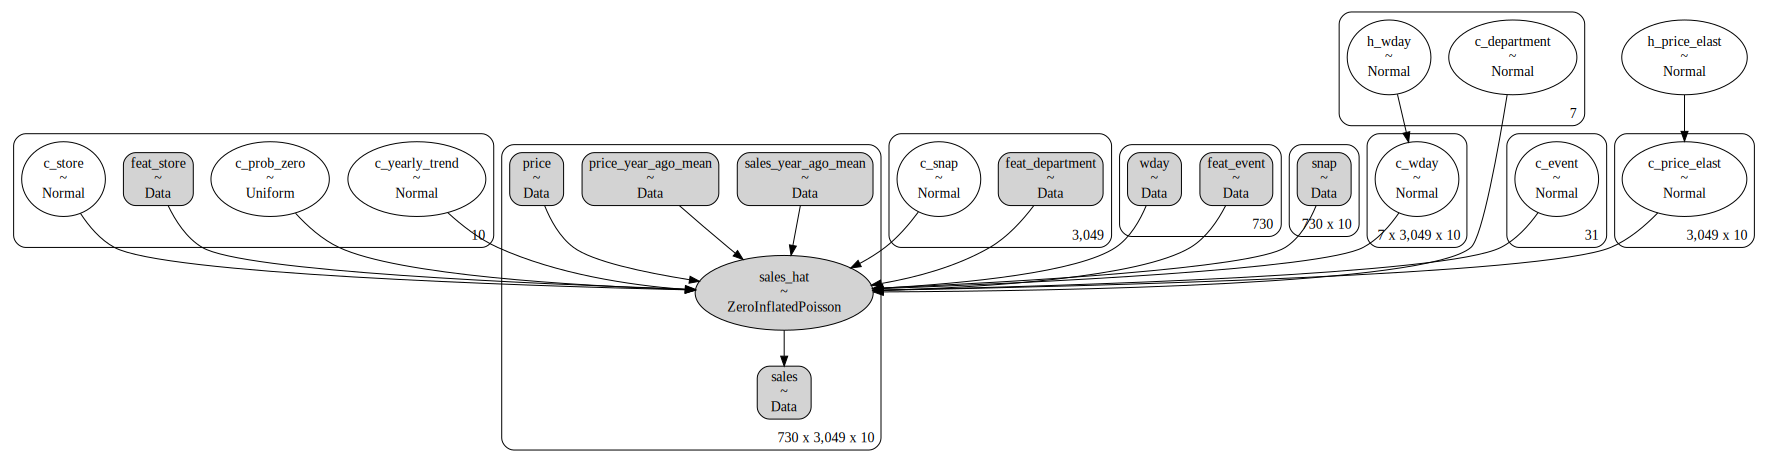

In [37]:
_gv = pm.model_to_graphviz(m)
_gv

In [38]:
with (__data__ / f"model_{xnow()}.dot").open(mode="w") as _f:
    _f.write(str(_gv))

### MAP

In [39]:
force_optimize = False
force_resample = False

In [40]:
path_map_params = __data__ / ("map_params.pkl")

# Load params
if path_map_params.exists():
    with path_map_params.open(mode="rb") as _f:
        start_params = pickle.load(_f)
else:
    start_params = None
    
# 
if (start_params is None) or force_optimize:
    with m:
        found_map = pm.find_MAP(start=start_params, maxeval=5000)
        
        with path_map_params.open(mode="wb") as _f:
            pickle.dump(found_map, _f)
else:
    found_map = start_params

In [41]:
# coeffs = [x for x in m.named_vars if x.startswith("c_") or x.startswith("h_") and not x.endswith("__")] 
# targets = ["sales"]

### MCMC (from MAP)

In [42]:
path_trace = __data__ / f"trace_fast.nc"
if force_resample or (not path_trace.exists()):
    with m:
        raw_trace_fast = pm.sample(
            step=pm.Metropolis(),
            draws=30,
            tune=10,
            chains=2,
            return_inferencedata=False,
            start=found_map,
        )

    with (__data__ / f"raw_trace_fast_{xnow()}.pkl").open(mode="wb") as _f:
        pickle.dump(raw_trace_fast, _f)

    with m:
        trace_fast = az.from_pymc3(raw_trace_fast)
        trace_fast.to_netcdf(path_trace)
else:
    with m:
        trace_fast = az.from_netcdf(path_trace)

Only 30 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [c_prob_zero]
>Metropolis: [c_snap]
>Metropolis: [c_price_elast]
>Metropolis: [h_price_elast]
>Metropolis: [c_wday]
>Metropolis: [h_wday]
>Metropolis: [c_event]
>Metropolis: [c_yearly_trend]
>Metropolis: [c_department]
>Metropolis: [c_store]


Sampling 2 chains for 10 tune and 30 draw iterations (20 + 60 draws total) took 3213 seconds.


0, dim: date, 730 =? 730
1, dim: item_id, 3049 =? 3049
2, dim: store_id, 10 =? 10


/home/anatoly/.conda/envs/m5-comp/lib/python3.8/site-packages/pymc3/sampling.py:642: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


0, dim: date, 730 =? 730
1, dim: item_id, 3049 =? 3049
2, dim: store_id, 10 =? 10


In [43]:
trace_fast

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [44]:
# with m:
#     advi = pm.ADVI()
#     tracker = pm.callbacks.Tracker(
#         mean=advi.approx.mean.eval,  # callable that returns mean
#         std=advi.approx.std.eval,  # callable that returns std
#     )
#     check_conv = pm.callbacks.CheckParametersConvergence(diff="absolute")
#     aprx = advi.fit(n=1000, callbacks=[tracker, check_conv])

#### In-sample

In [45]:
with m:
    ppc = pm.sample_posterior_predictive(trace_fast)

In [46]:
with m:
    ppc2 = az.from_pymc3(posterior_predictive=ppc, coords=D.coords)

In [47]:
ppc2

Inference data with groups:
	> posterior_predictive
	> observed_data

In [48]:
ins_raw = ppc2.posterior_predictive['sales_hat']
ins_avg = ins_raw.mean(dim=["chain", "draw"])

In [49]:
xy1_hat = xy1.copy()
xy1_hat['sales_hat'] = ins_avg

#### Out of sample

In [50]:
xy2 = ds.sel(date=dates_valid)

In [51]:
E = xy2.transpose("date", "item_id", "store_id", "event_name", ...)
with m:
    pm.set_data({k: E[k] for k in predictors+targets})
    raw_ppc_oos = pm.fast_sample_posterior_predictive(trace_fast)
    ppc_oos = az.from_pymc3(posterior_predictive=raw_ppc_oos, coords=E.coords)

In [52]:
oos_raw = ppc_oos.posterior_predictive['sales_hat']
oos_avg = oos_raw.mean(dim=["chain", "draw"])
oos_median = oos_raw.median(dim=["chain", "draw"])

In [53]:
xy2_hat = xy2.copy()
xy2_hat['sales_hat'] = oos_avg
# xy2_hat['sales_hat'] = oos_median

### Calculate error

The denominator is the MSE for the naive (1-step-ahead) forecast:

$$
mse_{naive} = \frac{1}{n-1} \sum_{t=2}^{n}{(Y_t-Y_{t-1})^2}
$$

We calculate error only after the first non-zero demand was observed.

The numerator is the MSE of your prediction, on the validation set:

$$
mse_{pred} = \frac{1}{h} \sum_{t=n+1}^{n+h} {(Y_t - \hat{Y_t})^2}
$$


The weights are just the value of sales during the last 28 days:

$$
w_i = \sum_{t=n-27}^{n}{Y_t \cdot price_t}
$$

Putting it all together, we get the Root Mean Squared Scaled Error (RMSSE):

$$
RMSSE = \sqrt{\frac{mse_{pred}}{mse_{naive}}}
$$

The weights are used to calculate the final metric (over all series):

$$
WRMSSE = \sum_{i=1}^{42840} {w_i * RMSSE_i}
$$

In [54]:
get_wrmsse(xy1, xy2_hat, t_hat="sales_hat")

1.2970403442449228

Note that an error greater than 1 means the forecast is worse than a 1-step-ahead naive/random walk forecast.
However, a 1-step-ahead forecast is impossible to use, because the forecast period is more than 1 day ahead.

In [55]:
errors_per_level = wrmsse_per_level(xy1, xy2_hat, t_hat="sales_hat")
errors_per_level

total            0.560091
state            1.495943
store            1.297040
cat              1.162798
dept             1.277899
state-cat        0.904945
state-dept       1.080504
store-cat        1.162798
store-dept       1.277899
product          1.297040
product-state    1.495943
product-store    1.297040
dtype: float64

This is the final error that would be shown on the leaderboard:

In [56]:
# result = wrmsse_total(xy1, xy2_hat, t_hat="sales_hat")
result = errors_per_level.mean()
result

1.1924951261049381

### Plot

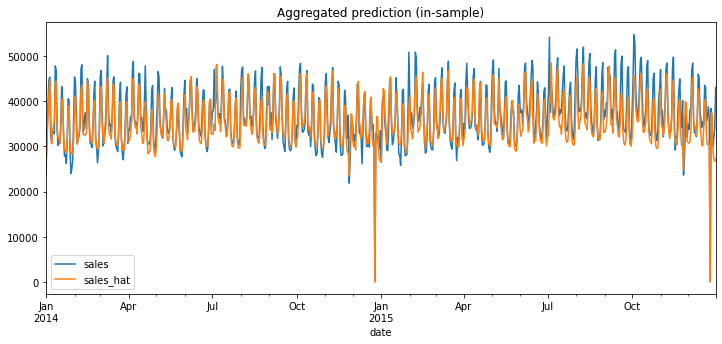

In [57]:
xy1_agg = xy1_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (in-sample)")
xy1_agg.to_dataframe().plot.line(ax=ax)
fig;

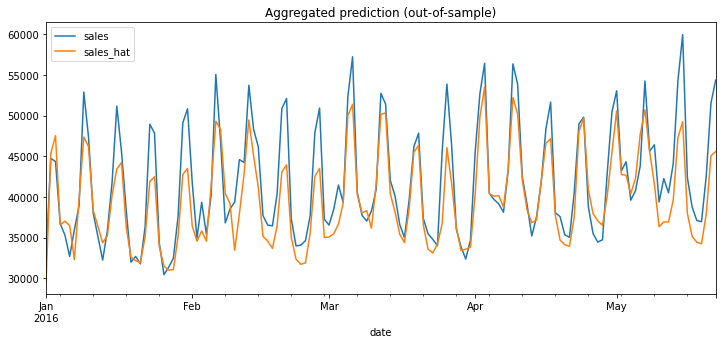

In [58]:
xy2_agg = xy2_hat[['sales', 'sales_hat']].groupby("date").sum(...)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Aggregated prediction (out-of-sample)")
xy2_agg.to_dataframe().plot.line(ax=ax)
fig;

### Coefficients

In [59]:
ppc_coef = trace_fast.posterior[["c_price_elast", "c_yearly_trend", "h_wday", "c_wday", "c_prob_zero"]]

In [60]:
c_price_elast = ppc_coef["c_price_elast"].mean(dim=["chain", "draw"])
avg_price_elast = c_price_elast.mean()
avg_price_elast

<xarray.DataArray 'c_price_elast' ()>
array(-0.60744604)

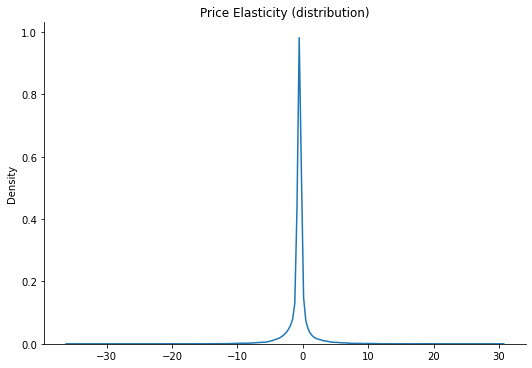

In [61]:
fg = sns.displot(c_price_elast.values.ravel(), kind='kde', aspect=1.5)
ax = fg.axes[0,0]
ax.set_title("Price Elasticity (distribution)")
fg;

In [63]:
trace_fast.posterior["h_price_elast"].mean()

<xarray.DataArray 'h_price_elast' ()>
array(-0.60743893)